## Image classification problem
We are going to tackle an image classification problem using a pretrained model from PyTorch. The selected model is ResNet18, a convolutional neural network with 18 hidden layers.
To begin, we load the necessary libraries.

In [4]:
import os
import shutil
import random
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import resnet18, ResNet18_Weights
import torch.optim as optim

The provided dataset is entirely contained in a folder named 'dogs'.
The first step is to split the dataset into two folders: 'train' and 'val', each containing images organized into subfolders according to their respective class.
This structure is necessary to use PyTorch’s ImageFolder class, which assumes this directory format for loading labeled image data.

In [5]:
def split_dataset(original_dir, output_dir, train_ratio=0.8):
    random.seed(42)

    # Remove previous folders if they exist
    for split in ['train', 'val']:
        split_path = os.path.join(output_dir, split)
        if os.path.exists(split_path):
            shutil.rmtree(split_path)

    classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

    for class_name in classes:
        class_path = os.path.join(original_dir, class_name)
        images = [img for img in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, img))]
        random.shuffle(images)

        train_size = int(len(images) * train_ratio)
        train_images = images[:train_size]
        val_images = images[train_size:]

        for split, split_images in zip(['train', 'val'], [train_images, val_images]):
            split_class_dir = os.path.join(output_dir, split, class_name)
            os.makedirs(split_class_dir, exist_ok=True)

            for img in split_images:
                src = os.path.join(class_path, img)
                dst = os.path.join(split_class_dir, img)
                shutil.copy2(src, dst)


original_dataset_path = "data/dogs"         # origiinal data    
output_dataset_path = "data/dataset_split"  # splited data

split_dataset(original_dataset_path, output_dataset_path, train_ratio=0.8)

Next, we need to load the data and prepare it for training.
Since we are working with a relatively small number of images, a good practice to improve training is to apply data augmentation, which allows us to provide the model with more diverse input from a limited dataset. This technique will be applied only to the training set.
Because we are using a pretrained model, we also normalize the dataset to match the preprocessing values used during the model’s pretraining.

In [6]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# Transforms para entrenamiento con augmentación
transform_augm = transforms.Compose([
    transforms.RandomResizedCrop(224),            
    transforms.RandomHorizontalFlip(),            
    transforms.RandomRotation(15),                
    transforms.ColorJitter(brightness=0.2, 
                           contrast=0.2,
                           saturation=0.2,
                           hue=0.1),              
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   
                         std=[0.229, 0.224, 0.225])
])




train_dataset = datasets.ImageFolder(output_dataset_path + "/train", transform=transform_augm)
val_dataset = datasets.ImageFolder(output_dataset_path + "/val", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

The model is loaded into the variable 'model'.

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)

model.fc = nn.Linear(model.fc.in_features, 4)  # 4 clases

model = model.to(device)

Next, the model is trained using the provided dataset.

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")

Epoch 1, Loss: 1.2876
Epoch 2, Loss: 0.7689
Epoch 3, Loss: 0.6024
Epoch 4, Loss: 0.4210
Epoch 5, Loss: 0.3347
Epoch 6, Loss: 0.2607
Epoch 7, Loss: 0.1592
Epoch 8, Loss: 0.1580
Epoch 9, Loss: 0.1926
Epoch 10, Loss: 0.1952


To evaluate the model, we use the validation dataset and calculate its accuracy.

In [9]:
model.eval()
results = []
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        # Calcular probabilidades y predicción
        probs = torch.nn.functional.softmax(outputs, dim=1)
        max_probs, pred_classes = torch.max(probs, dim=1)

        # Contar aciertos
        correct += (pred_classes == labels).sum().item()
        total += labels.size(0)

        # Guardar resultados para cada imagen
        for i in range(images.size(0)):
            results.append({
                'true_class': labels[i].item(),
                'predicted_class': pred_classes[i].item(),
                'confidence': max_probs[i].item()
            })


accuracy = correct / total
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.9375


To address the problem of classifying a new label "other," we could use the confidence score and find an appropriate threshold.
To do this, we can first plot a histogram of the confidence values and observe their behavior.

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

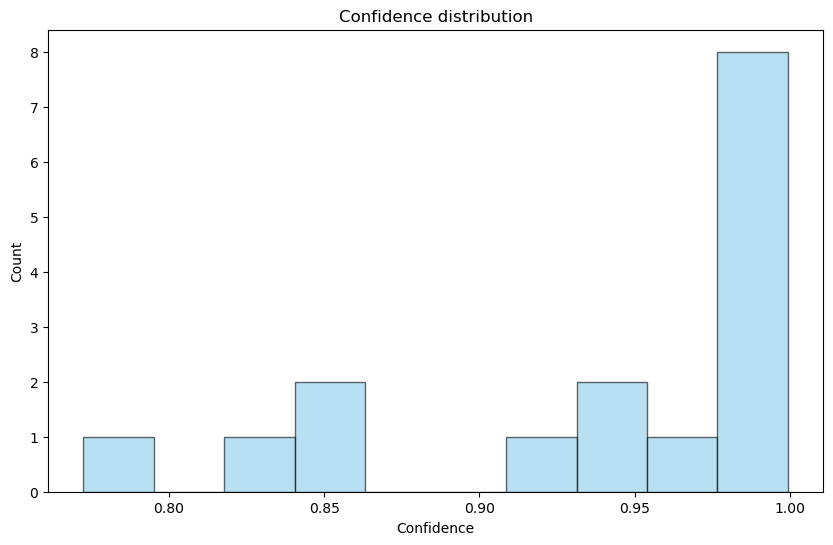

In [11]:
# pandas DataFrame
df = pd.DataFrame(results)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(df['confidence'], bins=10, color='skyblue', alpha=0.6, edgecolor='black')

plt.xlabel('Confidence')
plt.ylabel('Count')
plt.title('Confidence distribution')
plt.show()

We have very few data points to perform a thorough analysis of this new problem, but as an initial condition, we could choose a threshold of 0.85 to decide whether a sample belongs to the "other" class or not.
If data for the "other" class were available, the problem could even be approached as a binary classification task, where the threshold choice would depend on various criteria depending on the nature of the problem.
One approach could be to find the threshold value that maximizes the F1-score metric.

As a simple example, a dataset with an additional "other" category is loaded, and the model is used for its classification.

In [12]:
other_val_dataset = datasets.ImageFolder("data/val_with_other", transform=transform)
other_val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model.eval()
results = []
correct = 0
total = 0

class_names = train_dataset.classes
threshold = 0.85
other_class = True


with torch.no_grad():
    for images, labels in other_val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        probs = torch.nn.functional.softmax(outputs, dim=1)
        max_probs, pred_classes = torch.max(probs, dim=1)

        for i in range(images.size(0)):
            confidence = max_probs[i].item()
            true_class = class_names[labels[i].item()]

            # Clasificación como "other" si aplica
            if other_class and confidence < threshold:
                predicted_class = "other"
            else:
                predicted_class = class_names[pred_classes[i].item()]

            results.append({
                'true_class': true_class,
                'predicted_class': predicted_class,
                'confidence': confidence
            })

            # count if the prediction matches the true class (including the "other" class).
            if predicted_class == true_class:
                correct += 1

            total += 1

accuracy = correct / total
print(f"Validation Accuracy (with 'other'): {accuracy:.4f}")

Validation Accuracy (with 'other'): 0.7500


We see that this approach could be used as an alternative if the necessary training data is not available.